In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set_theme()
sns.set_style("ticks")
from multiprocessing import Pool as pool

In [3]:
import time

def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

In [4]:
################# PROBABILITY FUNCTIONS ################
def fxn(mean, arms):
    x = np.linspace(1, arms, arms)
    sig = 1.75
#     amp = 1/(sig*np.sqrt(2*np.pi))
    amp = 0.7
    vo = 0.1
    gx = (amp*np.exp(-0.5*((x-mean)**2)/(sig**2)))+vo
#     gx = np.random.permutation(gx)
    return gx

def cauchy(median, arms):
#     cauchy = @(x, s, t)(1./(s*pi*(1+(((x-t)./s).^2))))
    x = np.linspace(1, arms, arms)
    s = 1.5
    cauchy = ((1/(s*np.pi*(1+(((x-median)/s)**2))))*3.5)+0.1;
    return cauchy

In [5]:
################ ACTION SELECTION ####################
# epsilon greedy action selection
def epsilon_greedy(eps, actions, arms, value): 
    randn = np.random.uniform(0,1)
    if randn <= eps:
        actions = np.append(actions, np.random.randint(arms))
    else:
        actions = np.append(actions, np.random.choice(np.where(value == np.amax(value))[0]))
    return actions


# softmax action selection
def softmax(inv_temp, actions, arms, value):
    prob_choosing_action = np.zeros(len(arms))

    for arm in range(len(arms)):
        prob_choosing_action[arm] = (np.exp(value[arm]*inv_temp)) / np.sum(np.exp(value*inv_temp))
    actions = np.random.multinomial(1, prob_choosing_action)
    a = arms[actions.nonzero()[0][0]]
    return a, prob_choosing_action


# regret at each timestep for minimization?
def regret(action, prob_arms):
    reg = max(prob_arms) - prob_arms[action] 
    return reg


################ VALUE UPDATION #####################
def rewarding(prob, reward_val):
    temp = reward_val
    rand = np.random.uniform(0, 1)
    return temp if rand <= prob else 0

In [12]:
################ Q-LEARNER ##########################
def qlearn(alpha, inv_temp, trials, stream, n_arms):
    rng=stream
    arms = list(range(n_arms))
    rew_val = np.ones(n_arms)
    actions = []
    value = 0.5*np.ones(n_arms)
    sess_mean = rng.integers(low=1,high=n_arms+1) # check rng.integers docs - returns number between 1 and 8
    gx = fxn(sess_mean, n_arms)
    prob_arms = rng.permutation(gx)
#     prob_arms = np.copy(gx)    

#     median = rng.integers(low=1,high=n_arms+1)
#     gx = cauchy(median, n_arms)
#     rew_val = np.copy(gx)

    chance_level_sess = np.mean(prob_arms, axis = 0)
    
    rew_temp = []
    values = []
    regrets=[]
    ps = []
    
    for _ in range(trials):
        
        action, p = softmax(inv_temp, actions, arms, value)
#         actions = epsilon_greedy(eps, actions, arms, value)
        actions.append(action)
        ps.append(p)
        reg = regret(action, prob_arms)
        regrets.append(reg)
        reward = rewarding(prob_arms[int(action)], rew_val[int(action)])
        rew_temp.append(reward)
        value[int(action)] = value[int(action)] + alpha*(reward - value[int(action)]) 
        values.append(value)
        
    rew_sum = np.sum(rew_temp)
    rew_mean = np.mean(rew_temp)
    c_regrets = np.cumsum(regrets)
    return sess_mean, ps, actions, rew_temp, rew_sum, rew_mean, c_regrets 

In [14]:
trials = 150
sessions = 1000
arms = 10
init_values = 0.5*np.ones(arms) 
# alphas = np.sort(np.random.uniform(0, 1, size = 11))
# inv_temp = np.sort(np.random.uniform(0, 10, size = 11))

alphas = np.sort(np.linspace(0, 0.4, num = 11))
inv_temp = np.exp(np.linspace(-2, 6, num = 11))

In [ ]:
tic() # timekeeper

# specify for parallel processing
num_processes = 20
partitions = 20

# initialize for storage 
sess_mean, ps, actions, rewards, rew_sum, rew_mean, c_regrets = [], [], [], [], [], [], []
output= [[]*group for group in range(int(sessions/num_processes))]
sess_mean_matrix = np.zeros(shape = (len(alphas), len(inv_temp), sessions))
rew_sum_matrix = np.zeros(shape = (len(alphas), len(inv_temp), sessions))
rew_mean_matrix = np.zeros(shape = (len(alphas), len(inv_temp), sessions))
rew_sum_matrix = np.zeros(shape = (len(alphas), len(inv_temp), sessions))

c_regrets_matrix = np.zeros(shape = (len(alphas), len(inv_temp), sessions, trials))
actions_matrix = np.zeros(shape = (len(alphas), len(inv_temp), sessions, trials))
rewards_matrix = np.zeros(shape = (len(alphas), len(inv_temp), sessions, trials))
ps_matrix = np.zeros(shape = (len(alphas), len(inv_temp), sessions, trials, arms))


# generate diff stream of seeds for each process
ss = np.random.SeedSequence(4231)

for i, a in enumerate(alphas):
    for j, t in enumerate(inv_temp):
        for group in range(int(sessions/num_processes)):
            alpha_list = [a for k in range(partitions)]
            inv_temp_list = [t for k in range(partitions)]
            trials_list = [trials for k in range(partitions)]
            arms_list = [arms for k in range(partitions)]

            # Spawn off child SeedSequences to pass to child processes.
            child_seeds = ss.spawn(partitions)
            streams = [np.random.default_rng(s) for s in child_seeds]
            
            # from multiprocessing import Pool as pool
            # finally. begin process and storage
            with pool(num_processes) as p:
                output[group] = p.starmap(qlearn, zip(alpha_list, inv_temp_list, trials_list, streams, arms_list))
                
                # temporarily storing output of each process in a vector acc to sess 
                for sess in range(num_processes):
                    sess_mean.append(output[group][sess][0])
                    ps.append(output[group][sess][1])
                    actions.append(output[group][sess][2])
                    rewards.append(output[group][sess][3])
                    rew_sum.append(output[group][sess][4])
                    rew_mean.append(output[group][sess][5])
                    c_regrets.append(output[group][sess][6])
            
            print(f'computing for {a}, {t}', end = '\r')
            
        # storing whatever is generated into multidimensional arrays = what is the best way to do this?    
        for sess in range(sessions):    
            sess_mean_matrix[i, j, sess] = sess_mean[sess]
            rew_sum_matrix [i, j, sess] = rew_sum[sess] 
            rew_mean_matrix[i, j, sess] = rew_mean[sess]
            
            for trial in range(trials):
                actions_matrix[i, j, sess, trial] = actions[sess][trial] 
                rewards_matrix[i, j, sess, trial] = rewards[sess][trial]
                c_regrets_matrix[i, j, sess, trial] = c_regrets[sess][trial]
                
                for arm in range(arms):
                    ps_matrix[i, j, sess, trial, arm] = ps[sess][trial][arm]
        
        # reinitialize for next set of alpha, beta
        sess_mean, ps, actions, rew_sum, rew_mean, c_regrets = [], [], [], [], [], []
toc()            

In [ ]:
import pickle
temp = {'alphas':alphas, 'inv_temp':inv_temp, 'sess_mean':sess_mean_matrix, 'reward_sum': rew_sum_matrix,
        'reward_mean': rew_mean_matrix, 'actions': actions_matrix, 'rewards': rewards_matrix, 
        'c_regrets_matrix': c_regrets_matrix, 'ps_matrix': ps_matrix}

with open (f'plots/{arms}_{sessions}_unstr_sessions_data.pkl', 'wb') as file:
    pickle.dump(temp, file)

In [ ]:
# plotting mean of reward
fig = plt.figure(figsize = (9, 7))
ax = plt.subplot(1, 1, 1)
sns.heatmap(np.mean(rew_sum_matrix, axis = 2), yticklabels = np.round(alphas, 2), 
            xticklabels = np.round(inv_temp, 2), 
            cmap='mako', annot=True, linecolor='w', fmt='.1f')
ax.invert_yaxis()
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.title(f'Total reward obtained in a session, {sessions} sessions, {trials} trials, {arms} arms')
plt.ylabel(r'Learning rate ($\alpha$)')
plt.xlabel(r'Inverse Softmax temperature ($\beta$)')
plt.tight_layout()
plt.savefig(f'plots/tot_rew_unstr_{sessions}_{arms}.png', dpi=300)

In [ ]:
# plotting mean of reward/number of trials = reward rate over sessions
fig = plt.figure(figsize = (9, 7))
ax = plt.subplot(1, 1, 1)
sns.heatmap(np.mean(rew_sum_matrix/trials, axis = 2), yticklabels = np.round(alphas, 2), 
            xticklabels = np.round(inv_temp, 2), 
            cmap='mako', annot=True, linecolor='w')
ax.invert_yaxis()
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.title(f'Average reward obtained, {sessions} sessions, {trials} trials, {arms} arms')
plt.ylabel(r'Learning rate ($\alpha$)')
plt.xlabel(r'Inverse Softmax temperature ($\beta$)')
plt.tight_layout()
plt.savefig(f'plots/avg_rew_unstr_{sessions}_{arms}.png', dpi=300)

ValueError: Must pass 2-d input. shape=(11, 11, 150)

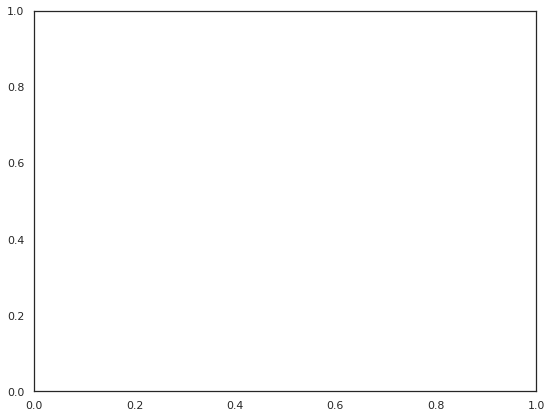

In [22]:
# plotting mean of cumulative regret/number of trials = Average regret over sessions
fig = plt.figure(figsize = (9, 7))
ax = plt.subplot(1, 1, 1)
sns.heatmap(data = np.mean(c_regrets_matrix/trials, axis = 2), yticklabels = np.round(alphas, 2), 
            xticklabels = np.round(inv_temp, 2), 
            cmap='flare', annot=True, linecolor='w')
ax.invert_yaxis()
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.title(f'Average regret, {sessions} sessions, {trials} trials')
plt.ylabel(r'Learning rate ($\alpha$)')
plt.xlabel(r'Inverse Softmax temperature ($\beta$)')
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize = (11, 5))
ax = plt.subplot(1, 1, 1)
sns.kdeplot(data = np.mean(rew_sum_matrix/trials, axis = 2), x = inv_temp, y = alphas, cmap ='icefire', fill=True,
            levels=20, cbar=True, common_norm = True)
plt.title(f'Average reward obtained, {sessions} sessions, {trials} trials')
plt.ylim((min(alphas),max(alphas)))
plt.xlim((min(inv_temp), max(inv_temp)))

# plt.xlim((min(inv_temp), 40))
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.ylabel(r'Learning rate ($\alpha$)')
plt.xlabel(r'Inverse Softmax temperature ($\beta$)')
plt.tight_layout()
# plt.savefig(f'plots/contour_{sessions}_{trials}_e4.png')

In [ ]:
# alphas = np.sort(np.linspace(0, 0.4, num = 11))
# inv_temp = np.exp(np.linspace(-0.5, 6, num = 11))
# rew_sum = []
# for i, a in enumerate(alphas):
#     for j, t in enumerate(inv_temp):
#         for proc in range(sessions):
            
#             rew_sum += qlearn(a, t, trials, np.random.default_rng(4231))

#             rew_sum_mat[i, j] = rew_sum
#         rew_sum =0
#         print(i, j, rew_sum_mat)
#     rew_sum = 0

In [ ]:
np.exp(np.linspace(-0.5,3, num=11))

In [ ]:
np.linspace(0.2, 0.6,num=11)

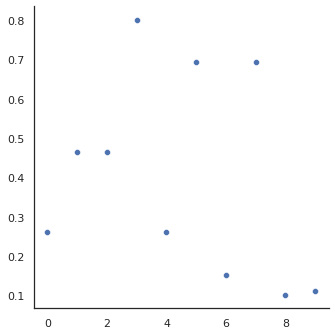

In [11]:
gx = fxn(4, 10)
sns.relplot(np.random.permutation(gx))

In [ ]:
# for i, a in enumerate(alphas):
#     for j, t in enumerate(inv_temp):
#         for sess in range(sessions):
#             rew_sum += qlearn(a, t)
#             rew_sum_mat[i, j] = rew_sum
#         rew_sum =0
#         print(i, j, rew_sum_mat)
#     rew_sum = 0

In [ ]:
time_taken = [0.000658, 0.000735, 65.8, 2029]
sess = [1, 10, 100, 1000]
plt.plot(np.log(sess), time_taken, 'o-')
